 # B3 daily MarketData 
 

In [38]:
#!pip install XlsxWriter
#!pip install ta-lib

In [39]:
# importando bibliotecas

#standard
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy as sco 
from scipy import stats
import math
import seaborn as sns
import requests
import io
import zipfile
import xlsxwriter

## finance library
import yfinance as yf
from pandas_market_calendars import get_calendar
from ta import add_all_ta_features
from ta.utils import dropna

path_marketdata = 'C:\\Users\\lucas\\OneDrive\\Finanças\\TickerMonitor\\'

# Instrument List from B3 (Brazilian Stock Exchange)

In [3]:
#https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/boletim-diario/dados-publicos-de-produtos-listados-e-de-balcao/
file_instlist = 'InstrumentsConsolidatedFile_20240401_1.csv'
df_inst = pd.read_csv(path_marketdata+file_instlist,sep = ';', encoding='unicode_escape', skiprows = 1, low_memory=False)
df_inst.head(2)

,RptDt,TckrSymb,Asst,AsstDesc,SgmtNm,MktNm,SctyCtgyNm,XprtnDt,XprtnCd,TradgStartDt,...,DaysToSttlm,SrsTpNm,PrtcnFlg,AutomtcExrcInd,SpcfctnCd,CrpnNm,CorpActnStartDt,CtdyTrtmntTpNm,MktCptlstn,CorpGovnLvlNm
0,2024-04-01,003H11,003H,003H,CASH,EQUITY-CASH,FUNDS,NaN,NaN,9999-12-31,...,2.0,NaN,NaN,NaN,CI,KINEA CO-INVESTIMENTO FDO INV IMOB,9999-12-31,FUNGIBLE,15000.0,NaN
1,2024-04-01,0FEA11,0FEA,0FEA,CASH,EQUITY-CASH,FUNDS,NaN,NaN,9999-12-31,...,2.0,NaN,NaN,NaN,CI,SPIM FUNDO DE INVESTIMENTO IMOBILIÁRIO,9999-12-31,FUNGIBLE,1631616.0,NaN


## Extracting all shares tickers registered

In [4]:
df_shares = df_inst[(df_inst['SctyCtgyNm'] == 'SHARES') & (df_inst['SgmtNm'] == 'CASH')][['RptDt','TckrSymb','SgmtNm','SctyCtgyNm','ISIN','Asst','SpcfctnCd','CrpnNm','MktCptlstn','CorpGovnLvlNm']].reset_index(drop = True)
df_shares.head(2)

,RptDt,TckrSymb,SgmtNm,SctyCtgyNm,ISIN,Asst,SpcfctnCd,CrpnNm,MktCptlstn,CorpGovnLvlNm
0,2024-04-01,2WAV3,CASH,SHARES,BR2WAVACNOR8,2WAV,ON MB,2W ECOBANK S.A.,113548407.0,MERCADO DE BALCÃO
1,2024-04-01,A6OP3,CASH,SHARES,BRA6OPACNOR7,A6OP,ON,ACESSOPAR INVESTIMENTOS E PARTICIPAÇÕES S.A.,1.0,NaN


# Extracting Shares prices

## Finding the most traded tickers from B3 website

In [5]:
#https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/boletim-diario/dados-publicos-de-produtos-listados-e-de-balcao/
file_tradings = 'TradeInformationConsolidatedFile_20240401_1.csv'
df_tradings = pd.read_csv(path_marketdata+file_tradings,sep = ';', encoding='unicode_escape', skiprows = 1, low_memory=False)
df_tradings['NtlFinVol'] = df_tradings['NtlFinVol'].str.replace(',','.').astype(float)
df_tradings.sort_values(by = ['NtlFinVol'],ascending = False, inplace = True)
df_tradings.head(2)

,RptDt,TckrSymb,ISIN,SgmtNm,MinPric,MaxPric,TradAvrgPric,LastPric,OscnPctg,AdjstdQt,AdjstdQtTax,RefPric,TradQty,FinInstrmQty,NtlFinVol
538,01/04/2024,WINJ24,BRBMEFWIN3A2,FINANCIAL,127305,129260,128066,127500,-1,127504,NaN,NaN,3322975.0,13526779.0,3.464640e+11
524,01/04/2024,WDOK24,BRBMEFWDO4B2,FINANCIAL,5024,5086,"5063,496",5068,"0,88","5081,207",NaN,NaN,559380.0,2665487.0,1.349670e+11


In [6]:
#adding most information like segment and company names to the trading tickers values downloaded
df_tradings = pd.merge(df_tradings,df_inst[['TckrSymb','SctyCtgyNm','CrpnNm','MktCptlstn','CorpGovnLvlNm']],on='TckrSymb',how = 'left')
df_tradings.head()

,RptDt,TckrSymb,ISIN,SgmtNm,MinPric,MaxPric,TradAvrgPric,LastPric,OscnPctg,AdjstdQt,AdjstdQtTax,RefPric,TradQty,FinInstrmQty,NtlFinVol,SctyCtgyNm,CrpnNm,MktCptlstn,CorpGovnLvlNm
0,01/04/2024,WINJ24,BRBMEFWIN3A2,FINANCIAL,127305,129260,128066,127500,-1,127504,NaN,NaN,3322975.0,13526779.0,3.464640e+11,NaN,NaN,NaN,NaN
1,01/04/2024,WDOK24,BRBMEFWDO4B2,FINANCIAL,5024,5086,"5063,496",5068,"0,88","5081,207",NaN,NaN,559380.0,2665487.0,1.349670e+11,NaN,NaN,NaN,NaN
2,01/04/2024,DOLK24,BRBMEFDOL777,FINANCIAL,5024,"5085,5","5068,35",5068,"0,88","5081,207",NaN,NaN,36978.0,419625.0,1.063400e+11,NaN,NaN,NaN,NaN
3,01/04/2024,DI1K24,BRBMEFD1I7T6,FINANCIAL,"10,654","10,666","10,66","10,666","0,07","99119,29","10,664",NaN,1190.0,572104.0,5.670671e+10,NaN,NaN,NaN,NaN
4,01/04/2024,DI1F25,BRBMEFD1I2Z4,FINANCIAL,"9,905","9,94","9,926","9,925","0,15","93044,65","9,924",NaN,16013.0,480096.0,4.466945e+10,NaN,NaN,NaN,NaN


In [7]:
#filtering only equity shares
df_tradshares = df_tradings[df_tradings['SctyCtgyNm'].isin(['SHARES','UNIT']) & (df_tradings['SgmtNm'].isin(['CASH']))].reset_index(drop = True)
df_tradshares.head(2)

,RptDt,TckrSymb,ISIN,SgmtNm,MinPric,MaxPric,TradAvrgPric,LastPric,OscnPctg,AdjstdQt,AdjstdQtTax,RefPric,TradQty,FinInstrmQty,NtlFinVol,SctyCtgyNm,CrpnNm,MktCptlstn,CorpGovnLvlNm
0,01/04/2024,ITUB4,BRITUBACNPR1,CASH,"33,43","34,79","33,7","33,44","-3,42",NaN,NaN,NaN,33207.0,31425600.0,1.055943e+09,SHARES,ITAU UNIBANCO HOLDING S.A.,4.845845e+09,NIVEL 1
1,01/04/2024,VALE3,BRVALEACNOR0,CASH,61,"61,9","61,3","61,22","0,64",NaN,NaN,NaN,36802.0,16740100.0,1.018661e+09,SHARES,VALE S.A.,4.539008e+09,NOVO MERCADO


## Downloading historical prices from yahoo finance

In [8]:
# building a dictionary with the top 10 most traded tickers to download the historical prices
tickers_dic = {value + '.SA' : value  for key, value in df_tradshares['TckrSymb'].head(10).items()}
tickers_dic

{'ITUB4.SA': 'ITUB4',
 'VALE3.SA': 'VALE3',
 'PETR4.SA': 'PETR4',
 'B3SA3.SA': 'B3SA3',
 'HAPV3.SA': 'HAPV3',
 'EQTL3.SA': 'EQTL3',
 'RENT3.SA': 'RENT3',
 'SUZB3.SA': 'SUZB3',
 'BBDC4.SA': 'BBDC4',
 'BBAS3.SA': 'BBAS3'}

In [9]:
######################################################################
amount_years = 1 # manual parameter: period desired to the historical data

today = date.today()
curr_date_today = today.strftime("%Y-%m-%d")  
curr_date_today_BR = today.strftime("%m-%d-%Y")  
init = datetime.now() + timedelta(days=(-365.25*amount_years)) #The initial data goes back 'amount_years' years ago.
date_start = init.strftime("%Y-%m-%d") 
date_start_BR = init.strftime("%m-%d-%Y")
print("Start Date: ", date_start, '\n' "End Date: ", curr_date_today)

print("Start Date brazilian format: ", date_start_BR, '\n' "End Date brazilian format: ", curr_date_today_BR)

Start Date:  2023-04-08 
End Date:  2024-04-07
Start Date brazilian format:  04-08-2023 
End Date brazilian format:  04-07-2024


In [10]:
# downloading prices of each tickers from yahoo finance library
df1 = pd.DataFrame()
df2 = pd.DataFrame()

for i in tickers_dic.keys():
    ticker = yf.Ticker(i)
    #print(ticker)
    df1 = ticker.history(start=date_start, end=curr_date_today)["Close"]
    df1 = df1.reset_index() 
    df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
    df1['Tickers'] = i
    df2 = pd.concat([df1, df2], ignore_index=True)
    
# trasnforming each tickers prices appended into a column at the dataframe    
df3 = pd.pivot_table(df2,
                  index = ['Date'],
                  columns =['Tickers'],
                  values = ['Close']).reset_index().droplevel(0, axis=1).rename(columns = {'':'Date'})  
df3['Date'] = pd.to_datetime(df3['Date'])
df3.set_index('Date', inplace=True)

# Get the BMF trading calendar

bmf_calendar = get_calendar('BMF')
trading_days = bmf_calendar.schedule(start_date=date_start, end_date=curr_date_today).sort_index(ascending=False) 
trading_days.index.names = ['Date']
trading_days = trading_days.reset_index()

#changing tickers names (dropping '.SA' prefix from brazilian tickers)
df3.rename(columns = tickers_dic,inplace = True)


#df3 = df3.iloc[2:] # *************corrigir problema da primeira linha com elemento nulo************
df3.sort_index(ascending = False).head()

Tickers,B3SA3,BBAS3,BBDC4,EQTL3,HAPV3,ITUB4,PETR4,RENT3,SUZB3,VALE3
Date,,,,,,,,,,
2024-04-05,12.00,57.009998,14.520000,31.889999,3.97,32.730000,38.099998,53.180000,62.810001,59.709999
2024-04-04,11.96,56.770000,14.560000,32.380001,4.01,32.790001,37.980000,53.410000,63.880001,60.369999
2024-04-03,11.70,56.389999,14.470000,32.299999,3.90,33.230000,38.419998,51.849998,64.599998,61.049999
2024-04-02,11.73,56.169998,14.190000,32.250000,3.89,33.480000,38.619999,52.439999,65.230003,61.939999
2024-04-01,11.77,56.080002,14.111025,31.969999,3.94,33.439999,37.650002,52.266457,64.889999,61.220001


# Calculating Trading Indicators 

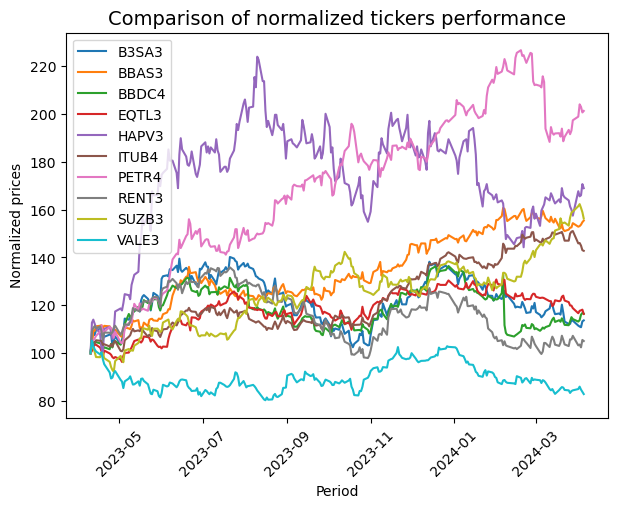

In [11]:
# normalized prices 
df_normprices = (df3/df3.iloc[0]*100) # taking first row as standard fixed 1 to normalization

#  plot
fig, ax = plt.subplots(figsize=[7, 5])
for col in df_normprices.columns:
    plt.plot(df_normprices[col], label=col) # label com a coluna do dataframe

ax.set_title('Comparison of normalized tickers performance', fontsize=14)
ax.set_xlabel('Period')
ax.set_ylabel('Normalized prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [12]:
'''
with pd.ExcelWriter(path_marketdata+'price_returnstop10_r01.xlsx', engine='xlsxwriter') as writer:
    df3.to_excel(writer,sheet_name = 'prices', index = True)
    prices_100.to_excel(writer,sheet_name = 'retorn_nomr', index = True)
'''

"\nwith pd.ExcelWriter(path_marketdata+'price_returnstop10_r01.xlsx', engine='xlsxwriter') as writer:\n    df3.to_excel(writer,sheet_name = 'prices', index = True)\n    prices_100.to_excel(writer,sheet_name = 'retorn_nomr', index = True)\n"

### Calculating SMA (Simple Moving Average)

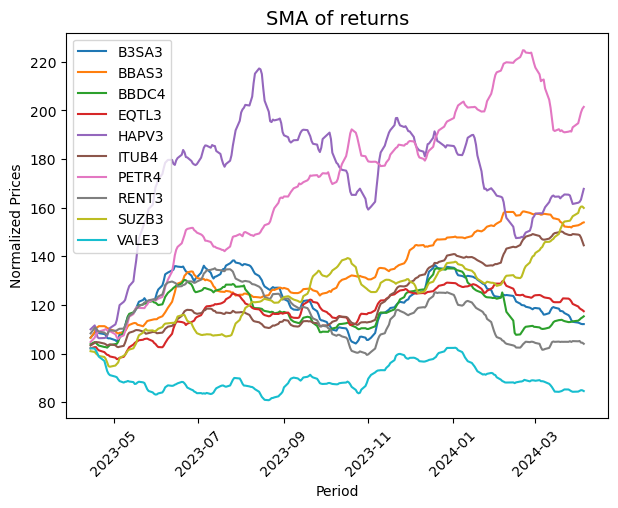

In [13]:
# Calculate the moving average for each stock ticker
df_sma = df_normprices.rolling(window = 5).mean()

#  plot the moving average 
fig, ax = plt.subplots(figsize=[7, 5])
for col in df_sma.columns:
    plt.plot(df_sma[col], label=col) # label com a coluna do dataframe

ax.set_title('SMA of returns', fontsize=14)
ax.set_xlabel('Period')
ax.set_ylabel('Normalized Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Calculating EWA (Exponentially-Weighted Average)

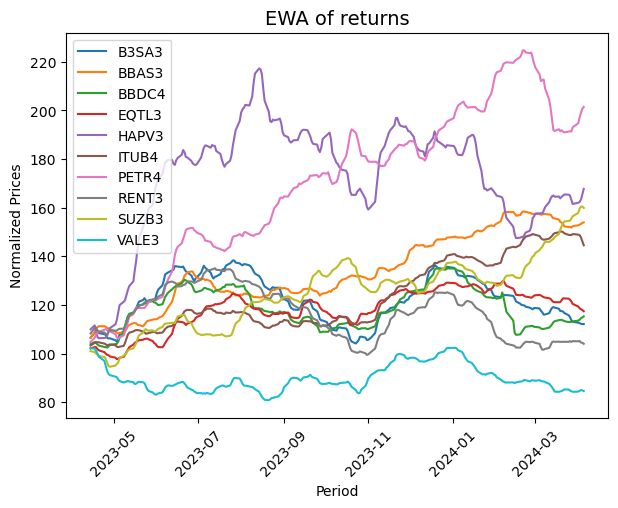

In [37]:
df_ewm = df_normprices.ewm(span = 5, # A smaller span means more weight is given to recent values.
                           min_periods=5, # ewma only be calculated for windows with at least 3 observations.
                           ).mean() 

#  plot the EWMA moving average 
fig, ax = plt.subplots(figsize=[7, 5])
for col in df_ewm.columns:
    plt.plot(df_sma[col], label=col) # label com a coluna do dataframe

ax.set_title('EWA of returns', fontsize=14)
ax.set_xlabel('Period')
ax.set_ylabel('Normalized Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Comparing SMA vs EWA at one ticker

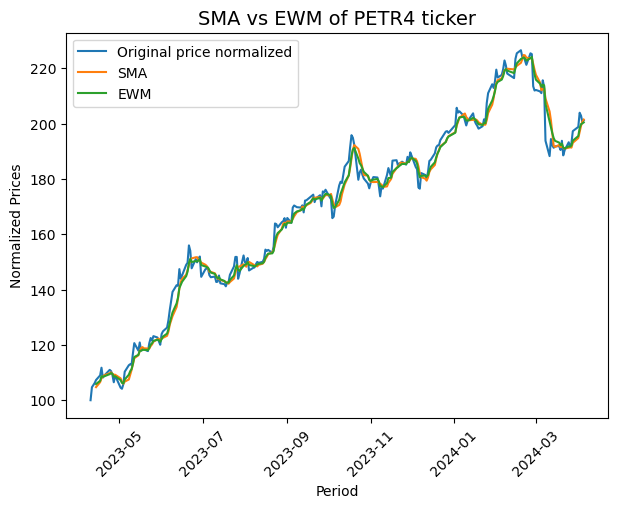

In [28]:
ticker_test = 'PETR4'
df_comp = pd.DataFrame()
df_comp['Original price normalized'] = df_normprices[[ticker_test]]
df_comp['SMA'] = df_sma[[ticker_test]]
df_comp['EWM'] = df_ewm[[ticker_test]]
df_comp.dropna()

#  plot the moving average 
fig, ax = plt.subplots(figsize=[7, 5])
for col in df_comp.columns:
    plt.plot(df_comp[col], label=col) # label com a coluna do dataframe

ax.set_title('SMA vs EWM of '+ticker_test+' ticker', fontsize=14)
ax.set_xlabel('Period')
ax.set_ylabel('Normalized Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Bollinger Bandas 

In [33]:
from ta.volatility import BollingerBands

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df3[ticker_test], window=10, window_dev=2)

df_bb = pd.DataFrame()
df_bb[ticker_test] = df3[ticker_test]
df_bb['h_band'] = indicator_bb.bollinger_hband()
df_bb['m_avg'] = indicator_bb.bollinger_mavg()
df_bb['l_band'] = indicator_bb.bollinger_lband()
df_bb['l_band_cross'] = indicator_bb.bollinger_lband_indicator() 
df_bb['h_band_cross'] = indicator_bb.bollinger_lband_indicator() 
df_bb.dropna(inplace = True)

In [34]:
#plot chart

import plotly.graph_objs as go

# Create a Plotly figure
fig = go.Figure()

# Add the price chart
fig.add_trace(go.Scatter(x=df_bb.index, y=df_bb[ticker_test], mode='lines', name='Price',line=dict(color='blue')))

# Add the Upper Bollinger Band (UB) and shade the area
fig.add_trace(go.Scatter(x=df_bb.index, y=df_bb['h_band'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_bb.index, y=df_bb['l_band'], fill='tonexty', mode='lines', name='Lower Bollinger Band', line=dict(color='green')))

# Add the Middle Bollinger Band (MA)
fig.add_trace(go.Scatter(x=df_bb.index, y=df_bb['m_avg'], mode='lines', name='Middle Bollinger Band', line=dict(color='gray',dash='dash')))

# Customize the chart layout
fig.update_layout(title=ticker_test+' Stock Price with Bollinger Bands',
                  xaxis_title='Date',
                  yaxis_title='Price [R$]',
                  showlegend=True)
# Show the chart
fig.show()

### Correlation map of returns

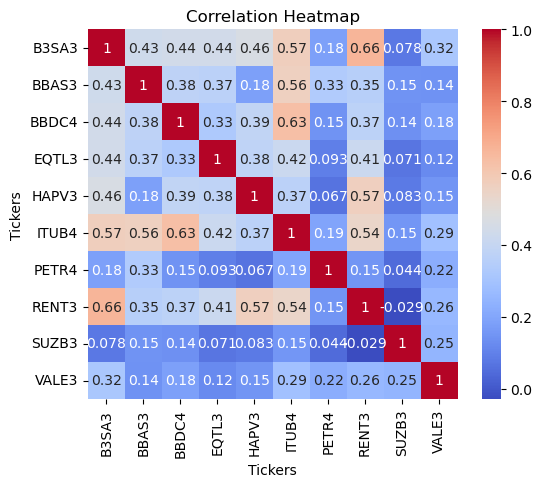

In [18]:
# calculating returns
returns = np.log(df3/df3.shift(1)).dropna()

# calculating and plotting a correlation heat map chart
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()